# Transfer learning with TensorFlow Hub

Example from [here](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub)

Old fix (not necessary): https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial

1. Installed miniforge [GitHub - conda-forge/miniforge: A conda-forge distribution.](https://github.com/conda-forge/miniforge#miniforge3)
2. [Installing TensorFlow 2.5 and Jupyter Lab on Mac with M1](http://blog.wafrat.com/installing-tensorflow-2-5-and-jupyter-lab-on-m1/)
3. 

In [1]:
import numpy as np
import time
import PIL.Image as Image

import matplotlib.pylab as plt

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

import datetime
%load_ext tensorboard

Init Plugin
Init Graph Optimizer
Init Kernel


In [3]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2

In [4]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

Metal device set to: Apple M1


2021-08-16 16:31:41.932814: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-08-16 16:31:41.932892: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


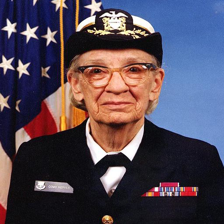

In [5]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [7]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

2021-08-16 16:31:42.726123: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-16 16:31:42.726377: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-08-16 16:31:42.813538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(1, 1001)

In [8]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=653>

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

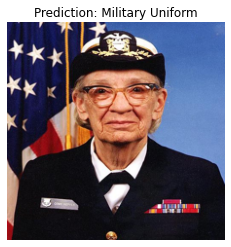

In [10]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Simple transfer learning

In [11]:
data_root = tf.keras.utils.get_file(
  'flower_photos',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

/Users/marco/.keras/datasets/flower_photos
3670


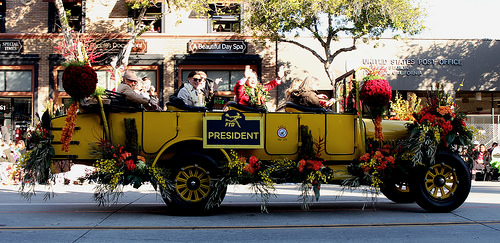

In [12]:
import pathlib

data_dir = pathlib.Path(str(data_root))
print(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

roses = list(data_dir.glob('roses/*'))
Image.open(str(roses[0]))

In [13]:
# ALTERNATIVE FOR TF < 2.2

#batch_size = 32
#img_height = 224
#img_width = 224

# create a data generator
#datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2, rescale=1./255)

#train_generator = datagen.flow_from_directory(
#    directory=str(data_root),
#    target_size=(img_height,img_width),
#    class_mode="categorical",
#    batch_size=batch_size,
#    subset="training"
#)
#train_ds = tf.data.Dataset.from_generator(lambda:
#                                          datagen.flow_from_directory(directory=str(data_root),
#                                                                      target_size=(img_height,img_width),
#                                                                      class_mode="categorical",
#                                                                      batch_size=batch_size,
#                                                                      subset="training"),
#                                          (tf.float32, tf.float32)
#                                         )

#val_ds = datagen.flow_from_directory(
#    directory=str(data_root),
#    target_size=(img_height,img_width),
#    class_mode="categorical",
#    batch_size=batch_size,
#    subset="validation"
#)

#type(train_ds)
#class_names = np.array(train_ds.class_names)
#print(class_names)

In [14]:
# This may not work as image_dataset_from_directory is not present in tf 2.0.0 (only from 2.3)

batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [15]:
class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [16]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [17]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


2021-08-16 16:32:01.002288: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Run the classifier on a batch of images

In [19]:
result_batch = classifier.predict(train_ds)

2021-08-16 16:32:58.704842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [20]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'coral fungus', 'rapeseed', ..., 'daisy', 'daisy',
       'birdhouse'], dtype='<U30')

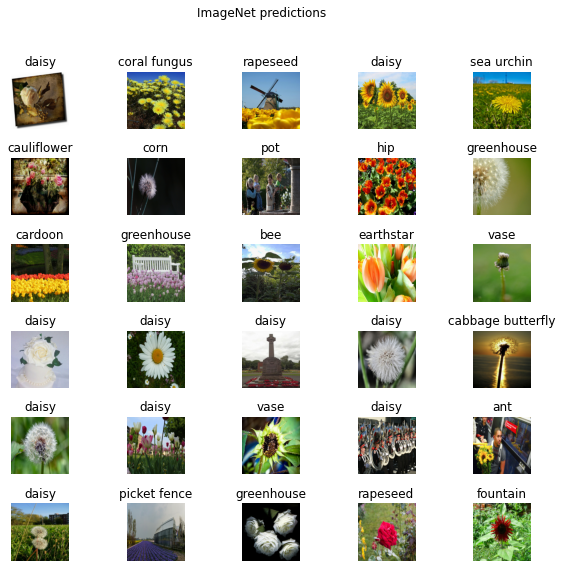

In [21]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

## Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

In [22]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [23]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [24]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

2021-08-16 16:38:36.599293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(32, 1280)


## Attach a classification head

In [25]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [26]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 5])

## Train the model

Use `Model.compile` to configure the training process and add a `tf.keras.callbacks.TensorBoar` callback to create and store logs

In [27]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

2021-08-16 16:45:09.214885: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-16 16:45:09.214913: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-08-16 16:45:09.215045: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [28]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10


2021-08-16 16:46:02.707417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/92 [..............................] - ETA: 3:36 - loss: 2.2796 - acc: 0.0938

2021-08-16 16:46:04.269087: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-16 16:46:04.269105: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


 2/92 [..............................] - ETA: 50s - loss: 2.0461 - acc: 0.1406 

2021-08-16 16:46:04.699413: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-08-16 16:46:04.703418: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-08-16 16:46:04.710432: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20210816-164509/train/plugins/profile/2021_08_16_16_46_04
2021-08-16 16:46:04.712743: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/fit/20210816-164509/train/plugins/profile/2021_08_16_16_46_04/MarcBookPro.local.trace.json.gz
2021-08-16 16:46:04.717945: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20210816-164509/train/plugins/profile/2021_08_16_16_46_04
2021-08-16 16:46:04.718097: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/fit/20210816-164509/train/plugins/profile/20

92/92 [==============================] - ETA: 0s - loss: 0.7793 - acc: 0.7197

2021-08-16 16:46:40.864773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 49s 517ms/step - loss: 0.7793 - acc: 0.7197 - val_loss: 0.4591 - val_acc: 0.8447
Epoch 2/10
92/92 [==============================] - 47s 511ms/step - loss: 0.3768 - acc: 0.8726 - val_loss: 0.3671 - val_acc: 0.8774
Epoch 3/10
92/92 [==============================] - 46s 503ms/step - loss: 0.2963 - acc: 0.9046 - val_loss: 0.3319 - val_acc: 0.8924
Epoch 4/10
92/92 [==============================] - 47s 508ms/step - loss: 0.2474 - acc: 0.9247 - val_loss: 0.3143 - val_acc: 0.8992
Epoch 5/10
92/92 [==============================] - 47s 510ms/step - loss: 0.2125 - acc: 0.9401 - val_loss: 0.3041 - val_acc: 0.9033
Epoch 6/10
92/92 [==============================] - 62s 675ms/step - loss: 0.1858 - acc: 0.9510 - val_loss: 0.2977 - val_acc: 0.8992
Epoch 7/10
92/92 [==============================] - 47s 509ms/step - loss: 0.1644 - acc: 0.9571 - val_loss: 0.2932 - val_acc: 0.9005
Epoch 8/10
92/92 [==============================] - 46s 501ms/step - loss: 0.146

In [29]:
%tensorboard --logdir logs/fit

## Check the predictions

Obtain the ordered list of class names from the model predictions:

In [30]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

2021-08-16 16:58:02.698892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


['roses' 'dandelion' 'tulips' 'sunflowers' 'dandelion' 'roses' 'dandelion'
 'roses' 'tulips' 'dandelion' 'tulips' 'tulips' 'sunflowers' 'tulips'
 'dandelion' 'roses' 'daisy' 'tulips' 'dandelion' 'dandelion' 'dandelion'
 'tulips' 'sunflowers' 'roses' 'sunflowers' 'dandelion' 'tulips' 'roses'
 'roses' 'sunflowers' 'tulips' 'sunflowers']


## Export and reload your model

In [31]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

2021-08-16 17:09:48.166031: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/saved_models/1629130187/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1629130187/assets


'/tmp/saved_models/1629130187'

In [32]:
reloaded = tf.keras.models.load_model(export_path)
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)
abs(reloaded_result_batch - result_batch).max()

2021-08-16 17:10:33.957286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


0.0

In [33]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

['roses' 'dandelion' 'tulips' 'sunflowers' 'dandelion' 'roses' 'dandelion'
 'roses' 'tulips' 'dandelion' 'tulips' 'tulips' 'sunflowers' 'tulips'
 'dandelion' 'roses' 'daisy' 'tulips' 'dandelion' 'dandelion' 'dandelion'
 'tulips' 'sunflowers' 'roses' 'sunflowers' 'dandelion' 'tulips' 'roses'
 'roses' 'sunflowers' 'tulips' 'sunflowers']


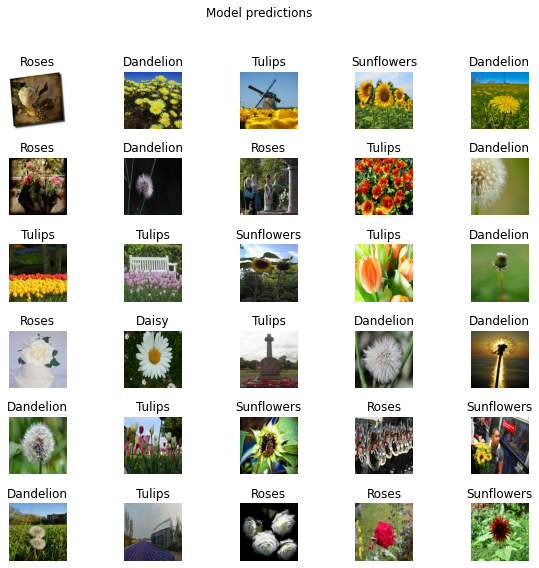

In [34]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")